## Import necessary libraries

In [62]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from prettytable import PrettyTable
import warnings
warnings.filterwarnings('ignore')


# Data Processing with Spark

In [73]:
# Initialize Spark Session
spark = SparkSession.builder.appName("OnlineRetailStoreAnalysis").getOrCreate()

# Load the dataset into Spark DataFrame
data_file = "Online Retail Data Set.csv"  
spark_df = spark.read.csv(data_file, header=True, inferSchema=True)

# Display schema
spark_df.printSchema()

# Data Cleaning: Drop rows with missing values
spark_df = spark_df.dropna()
print(spark_df.head())

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: integer (nullable = true)
 |-- Country: string (nullable = true)

Row(InvoiceNo='536365', StockCode='85123A', Description='WHITE HANGING HEART T-LIGHT HOLDER', Quantity=6, InvoiceDate='01-12-2010 08:26', UnitPrice=2.55, CustomerID=17850, Country='United Kingdom')


In [64]:
# Task 1: Mapper Functionality
def mapper(input_file):
    """
    Mapper function to process product quantities.
    Groups data by ProductID and prepares for reducer aggregation.
    Returns a list of tuples (ProductID, Quantity).
    """
    mapped_data = []
    with open(input_file, 'r') as file:
        next(file)  # Skip header
        for line in file:
            data = line.strip().split(',')
            if len(data) > 4:  # Ensure sufficient columns
                product_id = data[1]  # Assuming ProductID is in the second column
                quantity = data[3]  # Assuming Quantity is in the fourth column
                try:
                    mapped_data.append((product_id, int(quantity)))
                except ValueError:
                    continue  # Skip rows with invalid quantity values
    return mapped_data

# Task 2: Reducer Functionality
def reducer(mapped_data):
    """
    Reducer function to aggregate product quantities.
    Returns a dictionary with ProductID as key and total quantity as value.
    """
    from collections import defaultdict
    product_counts = defaultdict(int)
    for product_id, quantity in mapped_data:
        product_counts[product_id] += quantity
    return product_counts

# Run Mapper and Reducer
mapped_data = mapper(data_file)
reduced_data = reducer(mapped_data)

In [ ]:
# Display  Output 
print("\nReducer Output:")
table = PrettyTable()
table.field_names = ["ProductID", "TotalQuantity"]
for product_id, total_quantity in reduced_data.items():
    table.add_row([product_id, total_quantity])
print(table)


Reducer Output:
+--------------+---------------+
|  ProductID   | TotalQuantity |
+--------------+---------------+
|    85123A    |     38830     |
|    71053     |      1911     |
|    84406B    |      1422     |
|    84029G    |      3589     |
|    84029E    |      4660     |
|    22752     |      1666     |
|    21730     |      504      |
|    22633     |      4788     |
|    22632     |      4366     |
|    84879     |     36221     |
|    22745     |      2016     |
|    22748     |      2108     |
|    22749     |      2375     |
|    22310     |      668      |
|    84969     |      507      |
|    22623     |      924      |
|    22622     |      1329     |
|    21754     |      2760     |
|    21755     |      2030     |
|    21777     |       2       |
|    48187     |      3826     |
|    22960     |      8470     |
|    22913     |      348      |
|    22912     |      281      |
|    22914     |      463      |
|    21756     |      821      |
|    22728     |      5323

# Advanced Analytics and Machine Learning

In [74]:
from pyspark.sql.functions import rand

# Add a dummy SpendingScore column with random values for demonstration
spark_df = spark_df.withColumn("SpendingScore", (rand() * 100).cast("int"))

# Update selected columns to valid column names
selected_columns = ["Quantity", "UnitPrice", "SpendingScore"]
spark_df = spark_df.select(*selected_columns)

# Data Preprocessing: Assemble features into a single vector
feature_columns = ["Quantity", "UnitPrice"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
spark_df = assembler.transform(spark_df)

# Split the data into training and testing sets
train_df, test_df = spark_df.randomSplit([0.8, 0.2], seed=42)

# Model Training: Linear Regression
lr = LinearRegression(featuresCol="features", labelCol="SpendingScore")
lr_model = lr.fit(train_df)

# Model Evaluation on Test Data
predictions = lr_model.transform(test_df)
evaluator = RegressionEvaluator(
    labelCol="SpendingScore", predictionCol="prediction", metricName="rmse"
)
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Ensure predictions are not all zeros
predictions.show(5)


Root Mean Squared Error (RMSE): 28.922866880853572
+--------+---------+-------------+-------------+------------------+
|Quantity|UnitPrice|SpendingScore|     features|        prediction|
+--------+---------+-------------+-------------+------------------+
|    -500|     2.55|           15|[-500.0,2.55]|49.500013531937576|
|    -192|      2.1|           70| [-192.0,2.1]| 49.46812498054709|
|    -144|     0.72|           28|[-144.0,0.72]| 49.46230089028332|
|    -120|     1.06|           64|[-120.0,1.06]| 49.46006072799531|
|     -80|     0.42|           33| [-80.0,0.42]|  49.4555399992969|
+--------+---------+-------------+-------------+------------------+
only showing top 5 rows



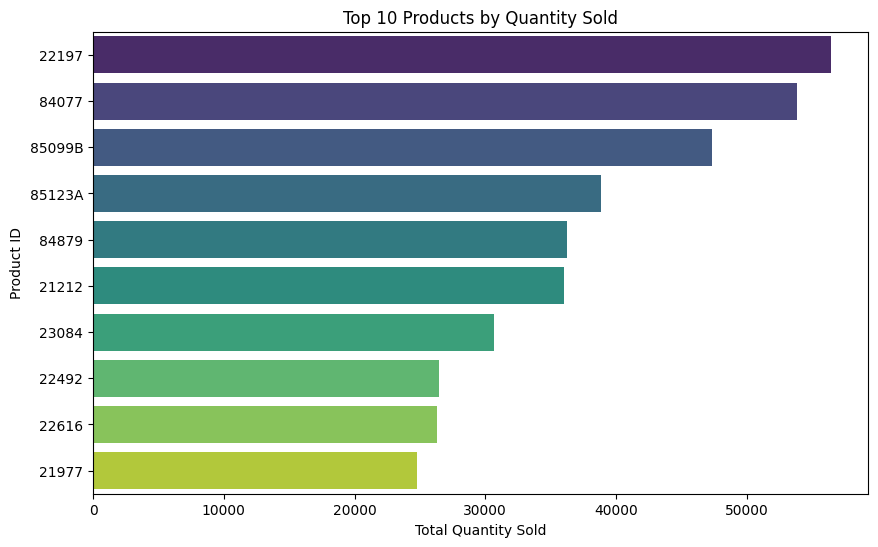

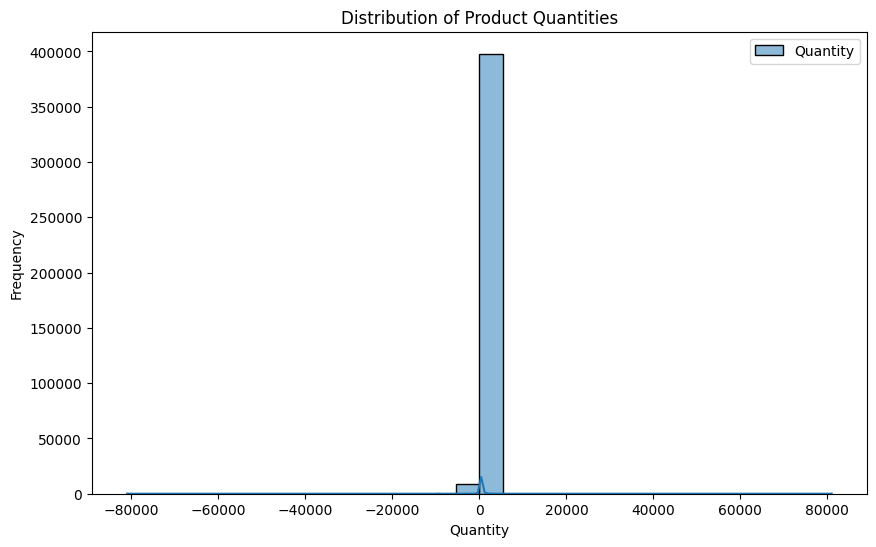

In [76]:

# Convert reducer output to Pandas DataFrame for visualization
reduced_df = pd.DataFrame(list(reduced_data.items()), columns=["ProductID", "TotalQuantity"])

# Visualization 1: Top 10 Products by Quantity Sold
top_products = reduced_df.sort_values("TotalQuantity", ascending=False).head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x="TotalQuantity", y="ProductID", data=top_products, palette="viridis")
plt.title("Top 10 Products by Quantity Sold")
plt.xlabel("Total Quantity Sold")
plt.ylabel("Product ID")
plt.show()
# Visualization 1: Distribution of Quantity
plt.figure(figsize=(10, 6))
sns.histplot(spark_df.select('Quantity').toPandas(), bins=30, kde=True, color='skyblue')
plt.title('Distribution of Product Quantities')
plt.xlabel('Quantity')
plt.ylabel('Frequency')
plt.show()

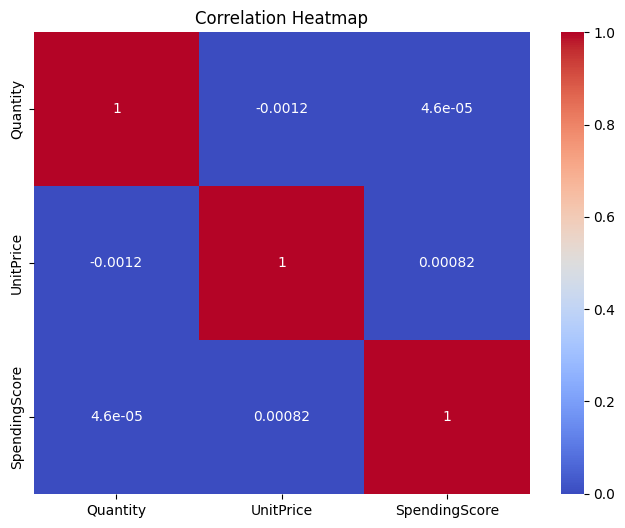

In [69]:
# Convert predictions to Pandas
predictions_pd = predictions.select("SpendingScore", "prediction").toPandas()

# Scatterplot for actual vs predicted spending scores
plt.figure(figsize=(10, 6))
plt.scatter(predictions_pd["SpendingScore"], predictions_pd["prediction"], alpha=0.6, color="blue")
plt.plot([predictions_pd["SpendingScore"].min(), predictions_pd["SpendingScore"].max()],
         [predictions_pd["SpendingScore"].min(), predictions_pd["SpendingScore"].max()],
         color="red", linestyle="--", label="Perfect Prediction")
plt.title("Actual vs Predicted Spending Scores")
plt.xlabel("Actual Spending Score")
plt.ylabel("Predicted Spending Score")
plt.legend()
plt.show()


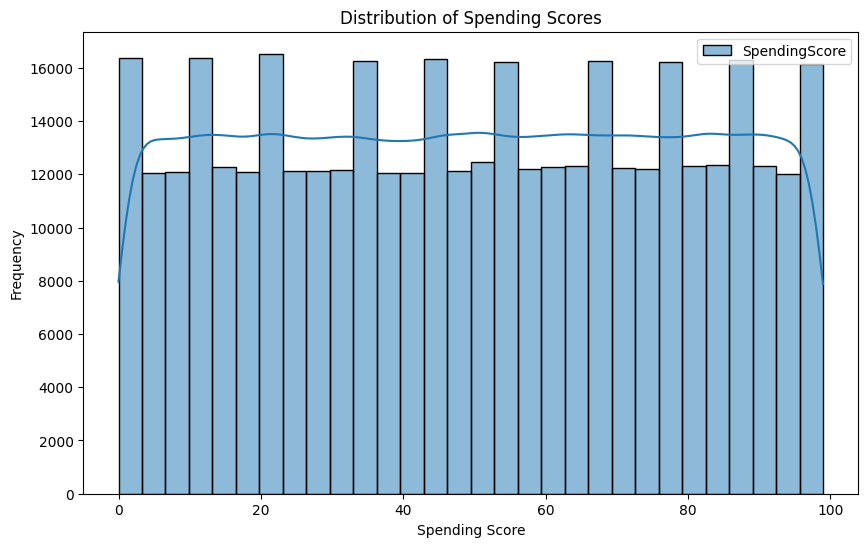

In [71]:
# Scatterplot for Unit Price vs Quantity
plt.figure(figsize=(8, 6))
sns.scatterplot(x='UnitPrice', y='Quantity', data=spark_df.select("UnitPrice", "Quantity").toPandas(), color='green', alpha=0.6)
plt.title('Unit Price vs Quantity')
plt.xlabel('Unit Price')
plt.ylabel('Quantity Sold')
plt.show()
